In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow import keras
from keras.utils.np_utils import to_categorical
from keras.utils import Progbar

from util import *

seed = 42
plt.rc('font', size=8)
plt.rc('axes', titlesize=8)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2023-05-25 10:13:46.107215: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 10:13:47.116178: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

seed_everything(seed)

## Extracting relevant features

Since, the dataset contains a lot of information we decided to use only u smal subset of features

In [ ]:
data = pd.read_parquet("data/job_table.parquet")
print(f"Number of features: {len(data.columns)}")

In [ ]:
# defining sets of data
columns = ["submit_time", "user_id", "group_id", "name", "command", "partition", "cpus_per_task",
           "num_cpus", "num_nodes", "num_tasks", "priority", "qos", "req_nodes", "time_limit",
           "tres_req_str", "year_month", "cpus_per_tres", "dependency", "ntasks_per_socket", "job_state"]
df = data[columns]
df = df[df.tres_req_str != ""]
df = df[(df.job_state != "CANCELLED") & (df.job_state != "NODE_FAIL")]
df.reset_index(drop=True, inplace=True)
df

In [ ]:
df.describe()

## Data selection

As first thing, try to understand how many missing values we had in the dataset

In [ ]:
df = df.replace('', np.nan)
print(df.isna().sum(axis=0))
prev_len = len(df)
print(f"Num of rows: {len(df)}")

As you can see *req_nodes*, *cpus_per_tres*, *dependency*, *ntasks_per_socket* are mostly NaN in this subset, so re drop that columns for the moment. For the other columns, as first thing let's remove all the rows that contains at least one NaN.

In [ ]:
df = df.drop(["req_nodes", "cpus_per_tres", "dependency", "ntasks_per_socket"], axis=1)
df = df.dropna().reset_index(drop=True)
print(df.isna().sum(axis=0))
print(f"Num of rows: {len(df)}")
print(f"Dropped rows: {prev_len - len(df)} ({(1-(len(df)/prev_len))*100:.1f} %)")

Set time zone to None

In [ ]:
df["submit_time"] = df["submit_time"].dt.tz_localize(None)

Save as pickle for more efficent usage

In [ ]:
df.to_pickle("data/job_table_reduced.pkl")

## Data fixing

In [ ]:
df =pd.read_pickle("data/job_table_reduced.pkl")
df["job_state"] = df["job_state"].astype(object)
df.head()

Let's inspect how data are

In [ ]:
df.dtypes

As you can see, a lot of data are string and these are difficult to use. So, try to convert it into better format

Start with those data types that are category

In [ ]:
cat_columns = df.select_dtypes(["category"]).columns
ord_enc =  OrdinalEncoder(dtype=np.int64)
for col in cat_columns:
    val = df[col].values.reshape(-1, 1)
    df[col] = ord_enc.fit_transform(val)
print(f"Categorical columns transformed: {cat_columns.values}")
print()
print(df.dtypes)

In [ ]:
df.head()

Now categorical data are in right format, move to integer columns.

In [ ]:
int_columns = ["user_id", "group_id", "cpus_per_task", "num_cpus", "num_nodes", "num_tasks", "priority", "time_limit"]
for col in int_columns:
    print(f"Check if all {col} are number: {all([item.isdigit() for item in df[col].unique()])}")

df[int_columns] = df[int_columns].apply(pd.to_numeric)
print()
print(df.dtypes)

for the moment ignore allocated value

In [ ]:
df = df.drop(["num_cpus", "num_nodes"], axis=1)

In [ ]:
df.head()

Now, it's time for *name* and *command*, we will try different approach for these two columns. Now, start with the basic one and use and Integer Encodig.

In [ ]:
string_columns = ["name", "command"]
ord_enc =  OrdinalEncoder(dtype=np.int64)
for col in string_columns:
    val = df[col].values.reshape(-1, 1)
    df[col] = ord_enc.fit_transform(val)
print(df.dtypes)

Now, for the *tres_req_str* we decide to split this column into 5 different columns

In [ ]:
# key = list(set([elem.split("=")[0] for row in df['tres_req_str'] for elem in row.split(",")]))
key = ['req_cpu', 'req_mem', 'req_node', 'req_billing', 'req_gres/gpu']
df["tres_req_str"] = df["tres_req_str"].apply(lambda row: ",".join([v.split("=")[1] for v in row.split(",")]))
df[key] =  df['tres_req_str'].str.split(",", expand=True)
df['req_mem'] = df['req_mem'].str.extract('(\d+)')
df = df.drop(["tres_req_str"], axis=1)
df[key] = df[key].fillna(0)
df[key] = df[key].astype(np.int64)

In [ ]:
df

In [ ]:
df.dtypes

## Data Anlaysis

In [ ]:
df = pd.read_pickle("data/job_table_r_preproc.pkl")
df.head()

In [ ]:
df.describe()

In [ ]:
sns.countplot(x=df["job_state"])
print(df.job_state.value_counts(normalize=True))

In [ ]:
cols = df.select_dtypes(include="int64").columns
fig, axs = plt.subplots(4, 4, figsize=(17, 13))
i, j = 0, 0
for col in cols:
    axs[i, j].hist(df[col])
    axs[i, j].set_title(col, fontweight="bold")
    j+=1
    if j%4 == 0:
        j = 0
        i +=1

In [ ]:
d = df.copy()
le = LabelEncoder()
d["job_state"] = le.fit_transform(d["job_state"])
sns.heatmap(d.corr())

## Exit state prediction

In [9]:
def get_data(path):
    df = pd.read_pickle("data/job_table_r_preproc.pkl")
    labels = df["job_state"]
    df = df.drop(["job_state", "submit_time"], axis=1)
    return df.to_numpy(), labels.to_numpy()

print("Loading data... ", end="")
data, labels = get_data("data/job_table_r_preproc.pkl")
print("Lodaded!")

Loading data... Lodaded!


### Using a NN

As first attempt we only consider 2 classes:
 - **0**: for completed job
 - **1**: for those failed
 
To do so, we firstly convert other failure classes into **FAILED**.

In [10]:
print(np.unique(labels))

labels[labels == "OUT_OF_MEMORY"] = "FAILED"
labels[labels == "TIMEOUT"] = "FAILED"

print(list(np.unique(labels)))

['COMPLETED' 'FAILED' 'OUT_OF_MEMORY' 'TIMEOUT']
['COMPLETED', 'FAILED']


Encode labels

In [11]:
def labels_encoding(labels, unique_labels):
    new_labels = []
    for label in labels:
        new_labels.append(unique_labels.index(label))
    return new_labels

unique_labels = list(np.unique(labels))
num_classes = len(unique_labels)

print(f"Old values: {labels[:5]}")
labels = labels_encoding(labels, unique_labels)
print(f"New values: {labels[:5]}")

Old values: ['COMPLETED' 'COMPLETED' 'COMPLETED' 'FAILED' 'COMPLETED']
New values: [0, 0, 0, 1, 0]


Split the data into train, validation and test sets and normalize using only train information

In [12]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size=0.7, random_state=seed)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8, random_state=seed)

x_train_mean = x_train.mean()
x_train_std = x_train.std()

x_train = (x_train - x_train_mean) / x_train_std
x_val = (x_val - x_train_mean) / x_train_std
x_test = (x_test - x_train_mean) / x_train_std

y_train = np.asarray(y_train, dtype=np.float32)
y_val = np.asarray(y_val, dtype=np.float32)
y_test = np.asarray(y_test, dtype=np.float32)

print(f"train data shape: {x_train.shape}")
print(f"val data shape: {x_val.shape}")
print(f"test data shape: {x_test.shape}")
print(f"train labels shape: {len(y_train)}")
print(f"val labels shape: {len(y_val)}")
print(f"test labels shape: {len(y_test)}")

train data shape: (546095, 16)
val data shape: (136524, 16)
test data shape: (292551, 16)
train labels shape: 546095
val labels shape: 136524
test labels shape: 292551


#### Work Stuff

Build the model

In [21]:
def build_model(input_shape, output_shape, hiddens):
    model_in = keras.Input(shape=input_shape)
    x = model_in
    for h in hiddens:
        x = keras.layers.Dense(h, activation='relu')(x)
    x = keras.layers.Dropout(0.3)(x)
    model_out = keras.layers.Dense(output_shape, activation="sigmoid")(x)
    model = keras.Model(model_in, model_out)
    return model

In [22]:
model = build_model((None, x_train.shape[1], ), 1, hiddens=[128, 128])
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.Adam(), 
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 16)]        0         
                                                                 
 dense_3 (Dense)             (None, None, 128)         2176      
                                                                 
 dense_4 (Dense)             (None, None, 128)         16512     
                                                                 
 dropout_1 (Dropout)         (None, None, 128)         0         
                                                                 
 dense_5 (Dense)             (None, None, 1)           129       
                                                                 
Total params: 18,817
Trainable params: 18,817
Non-trainable params: 0
_________________________________________________________________


In [23]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(x_train, y_train, epochs=50, validation_split=0.2, batch_size=256, callbacks=[callback])
plot_training_history(history)

Epoch 1/50


2023-05-24 22:23:11.898362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [436876]
	 [[{{node Placeholder/_11}}]]
2023-05-24 22:23:11.898686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [436876]
	 [[{{node Placeholder/_11}}]]


1696/1707 [============================>.] - ETA: 0s - loss: 0.2915 - accuracy: 0.8819

2023-05-24 22:23:18.196923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [109219]
	 [[{{node Placeholder/_11}}]]
2023-05-24 22:23:18.197200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [109219]
	 [[{{node Placeholder/_11}}]]


1707/1707 [==============================] - 7s 3ms/step - loss: 0.2913 - accuracy: 0.8819 - val_loss: 0.2630 - val_accuracy: 0.8869
Epoch 2/50
1707/1707 [==============================] - 5s 3ms/step - loss: 0.2538 - accuracy: 0.8899 - val_loss: 0.2434 - val_accuracy: 0.8923
Epoch 3/50
 678/1707 [==========>...................] - ETA: 2s - loss: 0.2438 - accuracy: 0.8922

KeyboardInterrupt: 

In [ ]:
y_pred = model.predict(x_test, batch_size=1024)
y_pred = tf.reshape(y_pred, y_pred.shape[0]).numpy()
y_pred = np.where(y_pred < 0.5, 0, 1)

# Create the confusion matrix
cm_nn = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_nn).plot()

f1 = f1_score(y_test, y_pred, average="binary")
print(f"F1 on test set: {f1}")

Weight the the loss function

In [ ]:
class WeightDecayBCE(keras.losses.Loss):
    def __init__(self, weights, from_logits=False,
                 reduction=keras.losses.Reduction.AUTO,
                 name='weighted_decay_bce'):
        super().__init__(reduction=reduction, name=name)
        self.weights = weights
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        weights_v = tf.where(tf.equal(y_true, 1), self.weights[1], self.weights[0])
        weights_v = tf.cast(weights_v, dtype=tf.float32)
        bce = keras.backend.binary_crossentropy(y_true, y_pred, from_logits=self.from_logits)
        loss = keras.backend.mean(tf.multiply(bce, weights_v))
        return loss

In [ ]:
weights = class_weight.compute_class_weight(class_weight='balanced',
                                            classes=np.unique(y_train),
                                            y=y_train)
weighted_bce = WeightDecayBCE(weights)

model2 = build_model((None, x_train.shape[1], ), 1, hiddens=[128, 128])
model2.compile(loss=weighted_bce,
              optimizer=keras.optimizers.Adam(), 
              metrics=["accuracy"])
model2.summary()

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history2 = model2.fit(x_train, y_train, epochs=50, validation_split=0.2, batch_size=256, callbacks=[callback])
plot_training_history(history2)

In [ ]:
y_pred = model2.predict(x_test, batch_size=1024)
y_pred = tf.reshape(y_pred, y_pred.shape[0]).numpy()
y_pred = np.where(y_pred < 0.5, 0, 1)

# Create the confusion matrix
cm_nn = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_nn).plot()

f1 = f1_score(y_test, y_pred, average="binary")
print(f"F1 on test set: {f1}")

#### Test classes

In [13]:
class WeightDecayBCE(keras.losses.Loss):
    def __init__(self, weights, from_logits=False,
                 reduction=keras.losses.Reduction.AUTO,
                 name='weighted_decay_bce'):
        super().__init__(reduction=reduction, name=name)
        self.one_weight = weights[1]
        self.zero_weight = weights[0]
        self.from_logits = from_logits

    def call(self, y_true, y_pred, step):
        weights_v = tf.where(tf.equal(y_true, 1), self.one_weight, self.zero_weight)
        weights_v = tf.cast(weights_v, dtype=tf.float32)
        bce = keras.backend.binary_crossentropy(y_true, y_pred, from_logits=self.from_logits)
        loss = keras.backend.mean(tf.multiply(bce, weights_v))
        return loss
    
# class TabMLP(keras.Model):
#     def __init__(self, output_shape=1, binary_task=True):
#         super(TabMLP, self).__init__()
#         self.d1 = keras.layers.Dense(128, activation='relu')
#         self.d2 = keras.layers.Dense(128, activation='relu')
#         self.do = keras.layers.Dropout(0.3)
#         self.classifier = keras.layers.Dense(output_shape, activation="sigmoid")

#     def call(self, inputs):
#         x = self.d1(inputs)
#         x = self.d2(x)
#         x = self.do(x)
#         return self.classifier(x)

In [28]:
def build_model(input_shape, output_shape, hiddens):
    model_in = keras.Input(shape=input_shape)
    x = model_in
    for h in hiddens:
        x = keras.layers.Dense(h, activation='relu')(x)
    x = keras.layers.Dropout(0.3)(x)
    model_out = keras.layers.Dense(output_shape, activation="sigmoid")(x)
    model = keras.Model(model_in, model_out)
    return model

In [38]:
batch_size = 256

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

weights = class_weight.compute_class_weight(class_weight='balanced',
                                            classes=np.unique(y_train),
                                            y=y_train)

loss_fn = WeightDecayBCE(weights)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=x_train.shape[0]).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)

In [33]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        out = model(x, training=True)
        loss_value = loss_fn(y, tf.squeeze(out))
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss_value

@tf.function
def val_step(x, y):
    out = model(x, training=False)
    loss_value = loss_fn(y, tf.squeeze(out))
    return loss_value

In [37]:
epochs = 30
train_length = len(train_dataset)
val_length = len(val_dataset)

# model = TabMLP()
model = build_model((x_train.shape[1], ), 1, [128,128])

# Iterate over epochs.
for epoch in range(epochs):
    e_tloss = 0
    e_vloss = 0
    print(f"\nEpoch {epoch+1}/{epochs}")

    pb = Progbar(train_length+1, stateful_metrics=["train_loss", "val_loss"])

    # train loop
    for step, (inputs, labels) in enumerate(train_dataset):
        loss = train_step(inputs, labels)
        e_tloss += loss
        pb.add(1, values=[("train_loss",e_tloss/(step+1))])
        
    # val loop
    for step, (inputs, labels) in enumerate(val_dataset):
        loss = val_step(inputs, labels)
        e_vloss += loss
    
    pb.add(1, values=[("val_loss",e_vloss/(step+1))])

# model.save_weights('checkpoints/tabMLP_wbce.h5')


Epoch 1/30


2023-05-25 11:08:33.834254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [546095,16]
	 [[{{node Placeholder/_0}}]]


2126/2135 [============================>.] - ETA: 0s - train_loss: 0.0458

2023-05-25 11:08:39.071106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [136524]
	 [[{{node Placeholder/_1}}]]


2135/2135 [==============================] - 6s 2ms/step - train_loss: 0.0458 - val_loss: 0.0443

Epoch 2/30
2135/2135 [==============================] - 6s 2ms/step - train_loss: 0.0459 - val_loss: 0.0443

Epoch 3/30
2135/2135 [==============================] - 6s 2ms/step - train_loss: 0.0457 - val_loss: 0.0455

Epoch 4/30
1481/2135 [===================>..........] - ETA: 1s - train_loss: 0.0456

KeyboardInterrupt: 

 160/1143 [===>..........................] - ETA: 0s

2023-05-25 11:08:09.358707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [292551,16]
	 [[{{node Placeholder/_10}}]]
2023-05-25 11:08:09.358914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [292551,16]
	 [[{{node Placeholder/_10}}]]


1143/1143 [==============================] - 1s 810us/step
F1 on test set: 0.6093372777041043


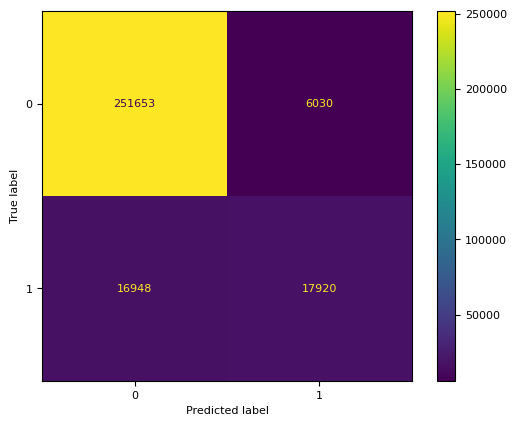

In [35]:
# model = TabMLP()
# model.load_weights("checkpoints/tabMLP_wbce.h5")

y_pred = model.predict(x_test, batch_size=256)
y_pred = tf.reshape(y_pred, y_pred.shape[0]).numpy()
y_pred = np.where(y_pred >= 0.5, 1, 0)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

f1 = f1_score(y_test, y_pred, average="binary")
print(f"F1 on test set: {f1}")

### ML Approach

In [ ]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
# rand_search = RandomizedSearchCV(rf, 
#                                  param_distributions = param_dist, 
#                                  n_iter=5, 
#                                  cv=5)
# # Fit the random search object to the data
# rand_search.fit(x_train[inputs], y_train)

rf.fit(x_train[inputs], y_train)

In [ ]:
y_pred = rf.predict(x_test[inputs])
f1 = f1_score(y_test, y_pred)
print("F1 on test set:", f1)

In [ ]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();